# Assignment 2
\- Yash Gupta (190997)

### Q1. (33 points)
Gabor filters are renowned for their functional equivalence to simple orientation-specific cells in primary visual cortex. I want you to design complex cells that can recognize  
(a) triangles and  
(b) squares  
using a bank of orientation-selective 2D Gabor filters. 

Let the base of the triangle and the square be horizontal and the triangle be an isosceles right-angled triangle with the top angle as the right angle. We can design complex cells for them without loss of generality. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

In [46]:
tri_img = cv2.imread('triangle.jpg')
sq_img = cv2.imread('square.jpg')
blank_img = cv2.imread('blank.jpg')

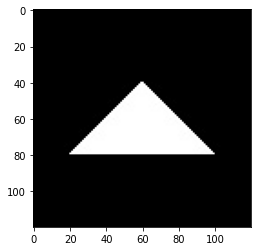

In [3]:
plt.imshow(tri_img)

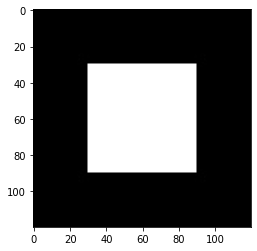

In [4]:
plt.imshow(sq_img)

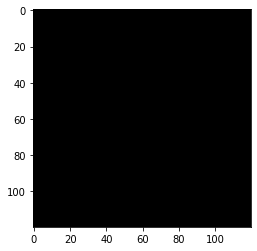

In [5]:
plt.imshow(blank_img)

As a part of preprocessing, we will dilate, erode and finally use thresholding to get sharp shapes. 

We will use a bank of 3 gabor filters for recognizing the triangle. They will be oriented at $\pi / 4$, $3 \pi / 4$ and $\pi / 2$ degrees to detect the left, right and the base edges of the triangle respectively.  
Similarly, for the square, we will be using a bank of 2 gabor filters oriented at 0 and $\pi / 2$ degrees to detect the horizontal and the vertical edges of the square respectively. 

Then we will take the intersection (by element-wise multiplication of the arrays) of these edges to get the corners of the shapes.  
Finally, we will test for both triangle and square. 

If the shape is a triangle, all the 3 corners should be existent after applying the 3 gabor filters defined for the triangle. A square will not produce these 3 corners.  
If the shape is a square, we should get corners after applying the horizontal and vertical gabor filters. A triangle will not produce any corner. 

In [49]:
def get_triangle_corners(img):
    ksize = (31, 31)
    sigma = 2
    lambd = 2
    gamma = 0.5
    psi = 0

    gabor_left = cv2.getGaborKernel(ksize, sigma, np.pi / 4, lambd, gamma, psi, ktype=cv2.CV_32F)
    img_left = cv2.filter2D(img, cv2.CV_8UC3, gabor_left)
    img_left = cv2.dilate(img_left, np.ones((5, 5)), iterations=2)
    img_left = cv2.erode(img_left, np.ones((5, 5)), iterations=2)
    blur = cv2.GaussianBlur(img_left, (5, 5), 0)
    _, thresh_left = cv2.threshold(blur, 180, 255, cv2.THRESH_BINARY)

    gabor_right = cv2.getGaborKernel(ksize, sigma, 3 * np.pi / 4, lambd, gamma, psi, ktype=cv2.CV_32F)
    img_right = cv2.filter2D(img, cv2.CV_8UC3, gabor_right)
    img_right = cv2.dilate(img_right, np.ones((5, 5)), iterations=2)
    img_right = cv2.erode(img_right, np.ones((5, 5)), iterations=2)
    blur = cv2.GaussianBlur(img_right, (5, 5), 0)
    _, thresh_right = cv2.threshold(blur, 180, 255, cv2.THRESH_BINARY)

    gabor_base = cv2.getGaborKernel(ksize, sigma, np.pi / 2, lambd, gamma, psi, ktype=cv2.CV_32F)
    img_base = cv2.filter2D(img, cv2.CV_8UC3, gabor_base)
    img_base = cv2.dilate(img_base, np.ones((5, 5)), iterations=2)
    img_base = cv2.erode(img_base, np.ones((5, 5)), iterations=2)
    blur = cv2.GaussianBlur(img_base, (5, 5), 0)
    _, thresh_base = cv2.threshold(blur, 180, 255, cv2.THRESH_BINARY)

    corner_left = np.uint8(thresh_left * thresh_base) * 255
    corner_right = np.uint8(thresh_right * thresh_base) * 255
    corner_top = np.uint8(thresh_left * thresh_right) * 255

    return [corner_left, corner_right, corner_top]

def get_square_corners(img):
    ksize = (31, 31)
    sigma = 2
    lambd = 2
    gamma = 0.5
    psi = 0

    gabor_horizontal = cv2.getGaborKernel(ksize, sigma, 0, lambd, gamma, psi, ktype=cv2.CV_32F)
    img_horizontal = cv2.filter2D(img, cv2.CV_8UC3, gabor_horizontal)
    img_horizontal = cv2.dilate(img_horizontal, np.ones((5, 5)), iterations=2)
    img_horizontal = cv2.erode(img_horizontal, np.ones((5, 5)), iterations=2)
    blur = cv2.GaussianBlur(img_horizontal, (5, 5), 0)
    _, thresh_horizontal = cv2.threshold(blur, 180, 255, cv2.THRESH_BINARY)

    gabor_vertical = cv2.getGaborKernel(ksize, sigma, np.pi / 2, lambd, gamma, psi, ktype=cv2.CV_32F)
    img_vertical = cv2.filter2D(img, cv2.CV_8UC3, gabor_vertical)
    img_vertical = cv2.dilate(img_vertical, np.ones((5, 5)), iterations=2)
    img_vertical = cv2.erode(img_vertical, np.ones((5, 5)), iterations=2)
    blur = cv2.GaussianBlur(img_vertical, (5, 5), 0)
    _, thresh_vertical = cv2.threshold(blur, 180, 255, cv2.THRESH_BINARY)

    corners = np.uint8(thresh_horizontal * thresh_vertical) * 255
    return corners

# check if img is a triangle
def check_triangle(img):
    corners = get_triangle_corners(img)
    for i in range(3):
        corner = np.asarray(np.nonzero(corners[i]))
        if corner.shape[1] == 0:
            return False
    return True

# checek if img is a square
def check_square(img):
    corners = get_square_corners(img)
    corners = np.asarray(np.nonzero(corners))
    if corners.shape[1] == 0:
        return False
    return True

def classify_image(img):
    img = np.uint8(np.mean(img, axis=2))
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if check_triangle(thresh):
        print('It is a triangle.')
        return 0
    if check_square(thresh):
        print('It is a square.')
        return 1
    print('It is neither a triangle nor a square.')
    return 2

Now, lets try classifying a few images:

It is a triangle.


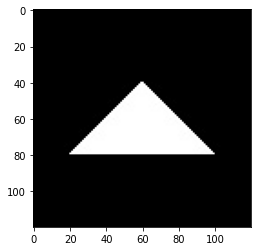

In [50]:
plt.imshow(tri_img)
tri_shape = classify_image(tri_img)

It is a square.


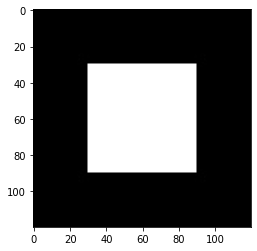

In [51]:
plt.imshow(sq_img)
sq_shape = classify_image(sq_img)

It is neither a triangle nor a square.


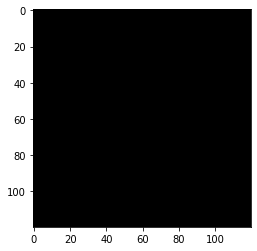

In [52]:
plt.imshow(blank_img)
blank_shape = classify_image(blank_img)

As we can see, we are able to classify the images successfully. 

### Q2. (33 points)
Once you have complex cells identifying triangles and squares, I want you to simulate the visual search paradigm of Triesman (1980), where the task is to find the odd stimulus in a set of objects. In our case, the objects will be red or blue in color and triangles or squares in shape. Simulating the paradigm means   being   able   to   enter   the   number   of   objects   and   experiment   type (feature/conjunction) as parameters and obtain image frames containing objects with these features as output. 

In [55]:
tri_img = cv2.imread('triangle.jpg', 0)
sq_img = cv2.imread('square.jpg', 0)

Let the environment be a 1440 x 1440 image which is divided into 144 blocks (12 rows of 12 blocks) of matrices of size 120 x 120

For the feature search paradigm, we will choose n random blocks from these 144 blocks and put triangles of a random color (either red or green) in these blocks. We will assign the other color to one of these n triangles randomly. This triangle will be the odd stimulus. 

In [63]:
def get_feature_search_env(n):
    env = np.zeros((1440, 1440, 3))
    color = np.random.choice(2)
    object_locs = np.random.permutation(np.arange(144))[:n]
    odd_stimulus_idx = np.random.choice(n)

    for i, loc in enumerate(object_locs):
        if i == odd_stimulus_idx:
            env[(loc // 12) * 120 : (loc // 12 + 1) * 120, (loc % 12) * 120 : (loc % 12 + 1) * 120, 1 - color] = tri_img
        else:
            env[(loc // 12) * 120 : (loc // 12 + 1) * 120, (loc % 12) * 120 : (loc % 12 + 1) * 120, color] = tri_img
    return env, object_locs

def get_conjunction_search_env(n):
    env = np.zeros((1440, 1440, 3))
    tri_color = np.random.choice(2)
    n_tri = np.random.choice(np.arange(1, n))
    n_sq = n - n_tri

    object_locs = np.random.permutation(np.arange(144))[:n]
    tri_locs = object_locs[:n_tri]
    sq_locs = object_locs[n_tri:]
    odd_stimulus_shape = np.random.choice(2)

    if odd_stimulus_shape == 0:
        odd_stimulus_idx = np.random.choice(n_tri)
        for i, loc in enumerate(tri_locs):
            if i == odd_stimulus_idx:
                env[(loc // 12) * 120 : (loc // 12 + 1) * 120, (loc % 12) * 120 : (loc % 12 + 1) * 120, 1 - tri_color] = tri_img
            else:
                env[(loc // 12) * 120 : (loc // 12 + 1) * 120, (loc % 12) * 120 : (loc % 12 + 1) * 120, tri_color] = tri_img
        
        for i, loc in enumerate(sq_locs):
            env[(loc // 12) * 120 : (loc // 12 + 1) * 120, (loc % 12) * 120 : (loc % 12 + 1) * 120, 1 - tri_color] = sq_img
    
    else:
        odd_stimulus_idx = np.random.choice(n_sq)
        for i, loc in enumerate(sq_locs):
            if i == odd_stimulus_idx:
                env[(loc // 12) * 120 : (loc // 12 + 1) * 120, (loc % 12) * 120 : (loc % 12 + 1) * 120, tri_color] = sq_img
            else:
                env[(loc // 12) * 120 : (loc // 12 + 1) * 120, (loc % 12) * 120 : (loc % 12 + 1) * 120, 1 - tri_color] = sq_img
        
        for i, loc in enumerate(tri_locs):
            env[(loc // 12) * 120 : (loc // 12 + 1) * 120, (loc % 12) * 120 : (loc % 12 + 1) * 120, tri_color] = tri_img
    
    return env, object_locs

def create_paradigm(n, ex_type):
    env, object_locs = get_feature_search_env(n) if ex_type == 'feature' else get_conjunction_search_env(n)
    return env, object_locs

Let us use these functions to create a feature search and a conjunction search paradigm:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


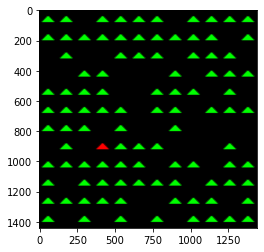

In [64]:
env, _ = create_paradigm(100, 'feature')
plt.imshow(env)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


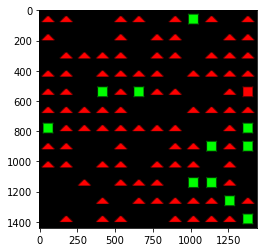

In [65]:
env, _ = create_paradigm(100, 'conjunction')
plt.imshow(env)

As we can see, we can successfully create these paradigms. 

### Q3. (34 points)
Once this paradigm is ready, I want you to implement a simple version of feature integration theory, viz. assume there is a matrix each for color and shape information, and that responses must be delayed until information from   all   relevant   stores   has   been   retrieved.   Can   add   timers   and   delays appropriately to simulate neural processing delays. As output, I want graphs of response time versus number of objects in both feature and conjunction search conditions. 

In [14]:
def identify_color(img):
    brightness_sum = np.sum(img, (0, 1))
    color = np.argmax(brightness_sum)
    return color

def get_feature_matrices(env, object_locs):
    n = len(object_locs)
    shape_mat = np.zeros(n)
    color_mat = np.zeros(n)
    for i, loc in enumerate(object_locs):
        img = env[(loc // 12) * 120 : (loc // 12 + 1) * 120, (loc % 12) * 120 : (loc % 12 + 1) * 120, :]
        shape_mat[i] = classify_image(img)
        color_mat[i] = identify_color(img)
    return shape_mat, color_mat

def feature_search(shape_mat, color_mat):
    tri_idx = np.asarray(np.nonzero(1 - shape_mat))
    sq_idx = np.asarray(np.nonzero(shape_mat))
    red_idx = np.array(np.nonzero(1 - color_mat))
    green_idx = np.array(np.nonzero(color_mat))

    if tri_idx.shape[1] == 1:
        return tri_idx[0]
    if sq_idx.shape[1] == 1:
        return sq_idx[0]
    if red_idx.shape[1] == 1:
        return red_idx[0]
    if green_idx.shape[1] == 1:
        return green_idx[0]
    
    time.sleep(0.02)
    return -1

def conjunction_search(shape_mat, color_mat):
    n = len(shape_mat)
    red_tri_idx = []
    green_tri_idx = []
    red_sq_idx = []
    green_sq_idx = []

    for i in range(n):
        if shape_mat[i] == 0:
            if color_mat[i] == 0:
                red_tri_idx.append(i)
            else:
                green_tri_idx.append(i)
        else:
            if color_mat[i] == 0:
                red_sq_idx.append(i)
            else:
                green_sq_idx.append(i)
        time.sleep(0.015)
    
    if len(red_tri_idx) == 1:
        return red_tri_idx[0]
    if len(green_tri_idx) == 1:
        return green_tri_idx[0]
    if len(red_sq_idx) == 1:
        return red_sq_idx[0]
    if len(green_sq_idx) == 1:
        return green_sq_idx[0]
    
    time.sleep(0.02)
    return -1

In [55]:
resp_time_fs = []
for n in range(2, 145):
    env, object_locs = create_paradigm(n, 'feature')
    shape_mat, color_mat = get_feature_matrices(env, object_locs)

    start = time.time()
    target_idx = feature_search(shape_mat, color_mat)
    resp_time_fs.append(time.time() - start)

In [56]:
resp_time_cs = []
for n in range(2, 145):
    env, object_locs = create_paradigm(n, 'conjunction')
    shape_mat, color_mat = get_feature_matrices(env, object_locs)

    start = time.time()
    target_idx = conjunction_search(shape_mat, color_mat)
    resp_time_cs.append(time.time() - start)

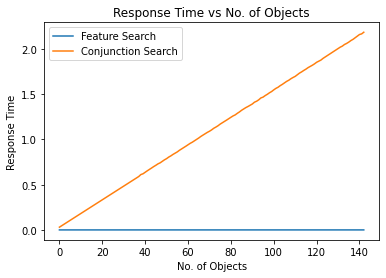

In [58]:
plt.plot(resp_time_fs, label='Feature Search')
plt.plot(resp_time_cs, label='Conjunction Search')
plt.ylabel('Response Time')
plt.xlabel('No. of Objects')
plt.title('Response Time vs No. of Objects')
plt.legend()
plt.show()